# Lesson 1: Cats and Dogs

## For Google Colab (Install pytorch-sconce first)

In [ ]:
!pip install pytorch-sconce==0.7.0
!pip install --no-cache-dir -I Pillow>=4.0.0

## Imports

In [2]:
from sconce import rate_controllers
from sconce.data_generators import ImageDataGenerator
from sconce.trainers import ClassifierTrainer
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import os
import torch
import torchvision

## Download cats and dogs data

In [3]:
if not os.path.exists('data'):
    !mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/
else:
    print("Data already downloaded, skipping...")

Data already downloaded, skipping...


## Define DataGenerators

In [4]:
image_size = 224

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

loader_kwargs = {
    'batch_size': 256,
    'shuffle': True,
    'num_workers': 0
}

training_data_generator = ImageDataGenerator.from_image_folder(
    root='data/dogscats/train',
    transform=transform,
    loader_kwargs=loader_kwargs)

test_data_generator = ImageDataGenerator.from_image_folder(
    root='data/dogscats/valid',
    transform=transform,
    loader_kwargs=loader_kwargs)

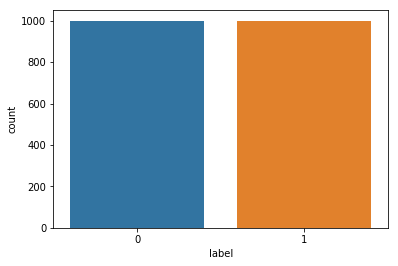

In [5]:
test_data_generator.plot_label_summary();

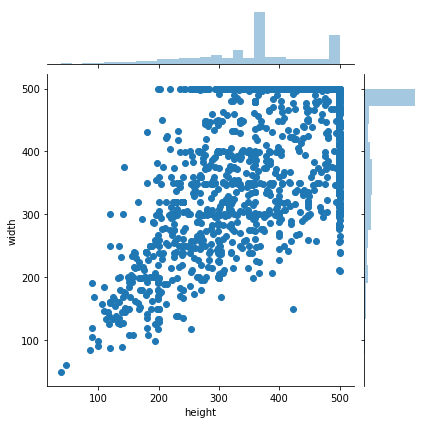

In [6]:
test_data_generator.plot_size_summary();

## Define Model

In [7]:
base_model = torchvision.models.resnet18(pretrained=True)

In [8]:
for param in base_model.parameters():
    param.requires_grad = False

In [9]:
base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)

In [10]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return {'outputs': x}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': F.nll_loss(input=outputs, target=targets)}

    def calculate_metrics(self, targets, outputs, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return {'classification_accuracy': classification_accuracy}

In [11]:
model = MyModel(base_model)

if torch.cuda.is_available():
    model.cuda()
    training_data_generator.cuda()
    test_data_generator.cuda()

## Construct Trainer

In [12]:
optimizer = optim.Adam(model.base_model.fc.parameters(),
        weight_decay=1e-4)

trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

## Survey for a Learning Rate

In [13]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=3)

31/45 [===================>..........] - ETA: 5s - loss: 0.4078

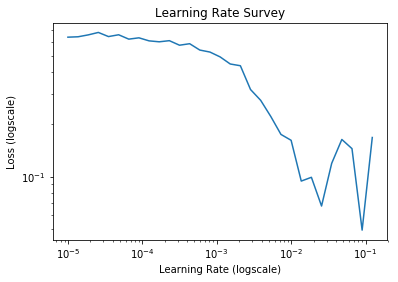

In [14]:
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

## Train Model

In [15]:
rc = rate_controllers.TriangleRateController(
    max_learning_rate=1e-2,
    min_learning_rate=2e-3)
trainer.train(num_epochs=0.9, rate_controller=rc);

81/81 [==============================] - 36s 450ms/step - loss: 0.1187 - val_loss: 0.0831


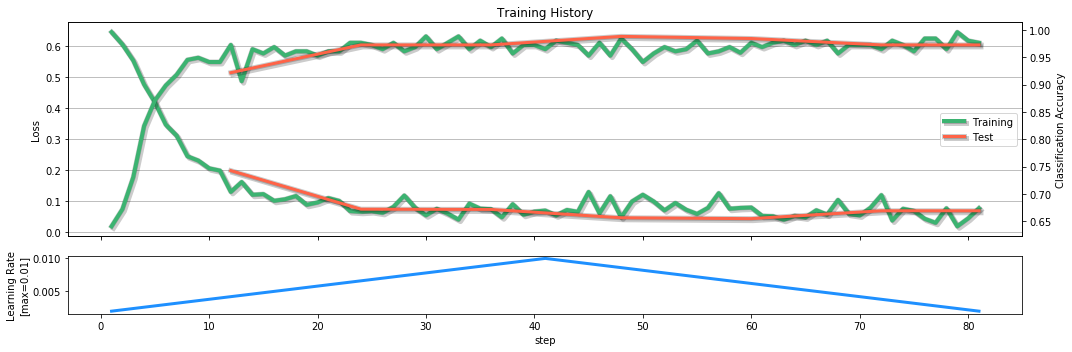

In [16]:
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'classification_accuracy']);

## Evaluate Model Predictions 

In [17]:
trainer.get_classification_accuracy()

0.98

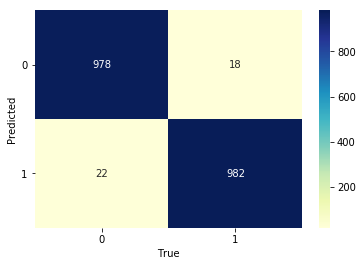

In [18]:
trainer.plot_confusion_matrix();

Misclassified as Dogs
Showing only the first 7 of 22 images


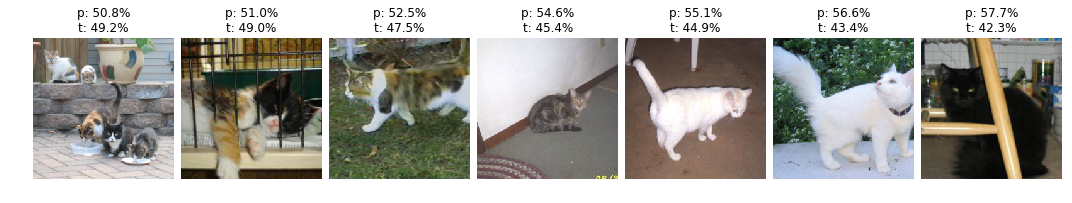

In [19]:
print("Misclassified as Dogs")
trainer.plot_samples(predicted_label=1, true_label=0);

Misclassified as Cats
Showing only the first 7 of 18 images


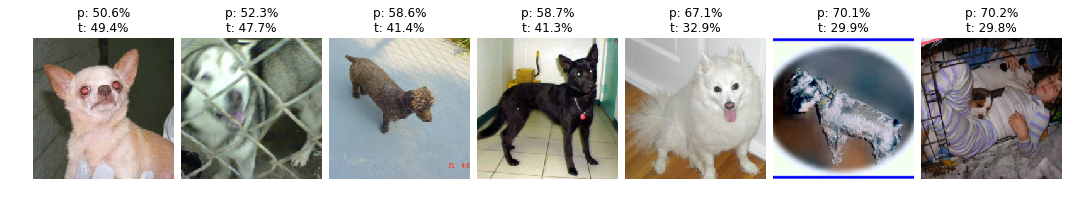

In [20]:
print("Misclassified as Cats")
trainer.plot_samples(predicted_label=0, true_label=1);

Most Dog-like Dogs
Showing only the first 7 of 982 images


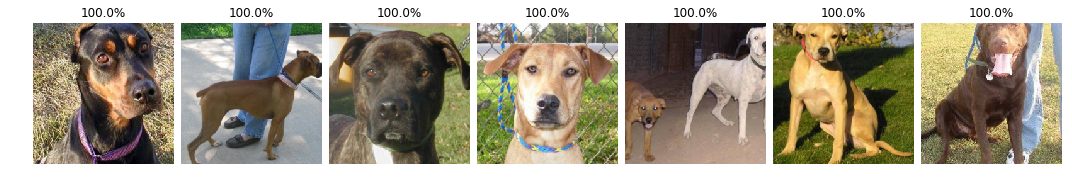

In [21]:
print("Most Dog-like Dogs")
trainer.plot_samples(predicted_label=1, true_label=1, sort_by='falling predicted label score');

Most Cat-like Cats
Showing only the first 7 of 978 images


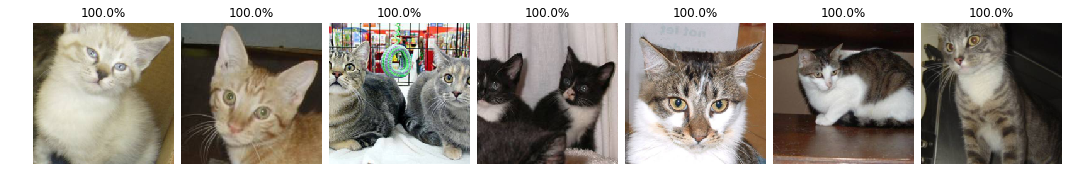

In [22]:
print("Most Cat-like Cats")
trainer.plot_samples(predicted_label=0, true_label=0, sort_by='falling predicted label score');